In [206]:
import re
from wikipedia import search, page
import gensim
from gensim.parsing import PorterStemmer
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
from networkx import Graph
from collections import defaultdict
import pygraphviz
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [207]:
global_stemmer = PorterStemmer()
 
class StemmingHelper(object):
    """
    Class to aid the stemming process - from word to stemmed form,
    and vice versa.
    The 'original' form of a stemmed word will be returned as the
    form in which its been used the most number of times in the text.
    """
 
    #This reverse lookup will remember the original forms of the stemmed
    #words
    word_lookup = {}
 
    @classmethod
    def stem(cls, word):
        """
        Stems a word and updates the reverse lookup.
        """
 
        #Stem the word
        stemmed = global_stemmer.stem(word)
 
        #Update the word lookup
        if stemmed not in cls.word_lookup:
            cls.word_lookup[stemmed] = {}
        cls.word_lookup[stemmed][word] = (
            cls.word_lookup[stemmed].get(word, 0) + 1)
 
        return stemmed
 
    @classmethod
    def original_form(cls, word):
        """
        Returns original form of a word given the stemmed version,
        as stored in the word lookup.
        """
 
        if word in cls.word_lookup:
            return max(cls.word_lookup[word].keys(),
                       key=lambda x: cls.word_lookup[word][x])
        else:
            return word

In [208]:
def _get_param_matrices(vocabulary, sentence_terms):
    """
    Returns
    =======
    1. Top 300(or lesser, if vocab is short) most frequent terms(list)
    2. co-occurence matrix wrt the most frequent terms(dict)
    3. Dict containing Pg of most-frequent terms(dict)
    4. nw(no of terms affected) of each term(dict)
    """
 
    #Figure out top n terms with respect to mere occurences
    n = min(300, len(vocabulary))
    topterms = list(vocabulary.keys())
    topterms.sort(key = lambda x: vocabulary[x], reverse = True)
    topterms = topterms[:n]
 
    #nw maps term to the number of terms it 'affects'
    #(sum of number of terms in all sentences it
    #appears in)
    nw = {}
    #Co-occurence values are wrt top terms only
    co_occur = {}
    #Initially, co-occurence matrix is empty
    for x in vocabulary:
        co_occur[x] = [0 for i in range(len(topterms))]
 
    #Iterate over list of all sentences' vocabulary dictionaries
    #Build the co-occurence matrix
    for sentence in sentence_terms:
        total_terms = sum(list(sentence.values()))
        #This list contains the indices of all terms from topterms,
        #that are present in this sentence
        top_indices = []
        #Populate top_indices
        top_indices = [topterms.index(x) for x in sentence
                       if x in topterms]
        #Update nw dict, and co-occurence matrix
        for term in sentence:
            nw[term] = nw.get(term, 0) + total_terms
            for index in top_indices:
                co_occur[term][index] += (sentence[term] *
                                          sentence[topterms[index]])
 
    #Pg is just nw[term]/total vocabulary of text
    Pg = {}
    N = sum(list(vocabulary.values()))
    for x in topterms:
        Pg[x] = float(nw[x])/N
 
    return topterms, co_occur, Pg, nw

In [209]:
def get_top_n_terms(vocabulary, sentence_terms, n=50):
    """
    Returns the top 'n' terms from a block of text, in the form of a list,
    from most important to least.
 
    'vocabulary' should be a dict mapping each term to the number
    of its occurences in the entire text.
    'sentence_terms' should be an iterable of dicts, each denoting the
    vocabulary of the corresponding sentence.
    """
 
    #First compute the matrices
    topterms, co_occur, Pg, nw = _get_param_matrices(vocabulary,
                                                     sentence_terms)
 
    #This dict will map each term to its weightage with respect to the
    #document
    result = {}
 
    N = sum(list(vocabulary.values()))
    #Iterates over all terms in vocabulary
    for term in co_occur:
        term = str(term)
        org_term = str(term)
        for x in Pg:
            #expected_cooccur is the expected cooccurence of term with this
            #term, based on nw value of this and Pg value of the other
            expected_cooccur = nw[term] * Pg[x]
            #Result measures the difference(in no of terms) of expected
            #cooccurence and  actual cooccurence
            result[org_term] = ((co_occur[term][topterms.index(x)] -
                                 expected_cooccur)**2/ float(expected_cooccur))
 
    terms = list(result.keys())
    terms.sort(key=lambda x: result[x],
               reverse=True)
 
    return terms[:n]

In [210]:
def build_mind_map(model, stemmer, root, nodes, alpha=0.2):
    """
    Returns the Mind-Map in the form of a NetworkX Graph instance.
 
    'model' should be an instance of gensim.models.Word2Vec
    'nodes' should be a list of terms, included in the vocabulary of
    'model'.
    'root' should be the node that is to be used as the root of the Mind
    Map graph.
    'stemmer' should be an instance of StemmingHelper.
    """
 
    #This will be the Mind-Map
    g = nx.DiGraph()
 
    #Ensure that the every node is in the vocabulary of the Word2Vec
    #model, and that the root itself is included in the given nodes
    for node in nodes:
        if node not in model.vocab:
            raise ValueError(node + " not in model's vocabulary")
    if root not in nodes:
        raise ValueError("root not in nodes")
 
    ##Containers for algorithm run
    #Initially, all nodes are unvisited
    unvisited_nodes = set(nodes)
    #Initially, no nodes are visited
    visited_nodes = set([])
    #The following will map visited node to its contextual vector
    visited_node_vectors = {}
    #Thw following will map unvisited nodes to (closest_distance, parent)
    #parent will obviously be a visited node
    node_distances = {}
 
    #Initialization with respect to root
    current_node = root
    visited_node_vectors[root] = model[root]
    unvisited_nodes.remove(root)
    visited_nodes.add(root)
 
    #Build the Mind-Map in n-1 iterations
    for i in range(1, len(nodes)):
        #For every unvisited node 'x'
        for x in unvisited_nodes:
            #Compute contextual distance between current node and x
            dist_from_current = cosine(visited_node_vectors[current_node],
                                       model[x])
            #Get the least contextual distance to x found until now
            distance = node_distances.get(x, (100, ''))
            #If current node provides a shorter path to x, update x's
            #distance and parent information
            if distance[0] > dist_from_current:
                node_distances[x] = (dist_from_current, current_node)
 
        #Choose next 'current' as that unvisited node, which has the
        #lowest contextual distance from any of the visited nodes
        next_node = min(unvisited_nodes,
                        key=lambda x: node_distances[x][0])
 
        ##Update all containers
        parent = node_distances[next_node][1]
        del node_distances[next_node]
        next_node_vect = ((1 - alpha)*model[next_node] +
                          alpha*visited_node_vectors[parent])
        visited_node_vectors[next_node] = next_node_vect
        unvisited_nodes.remove(next_node)
        visited_nodes.add(next_node)
 
        #Add the link between newly selected node and its parent(from the
        #visited nodes) to the NetworkX Graph instance
        g.add_edge(stemmer.original_form(parent).capitalize(),
                   stemmer.original_form(next_node).capitalize())
 
        #The new node becomes the current node for the next iteration
        current_node = next_node
 
    return g

In [211]:
def decorate(decorator):
    '''
    Decorator wrapper - decorator(func(text))
    '''
    def decoratorFn(func):
        def wrap(text):
            return decorator(func(text))
        return wrap
    return decoratorFn

def loop(decorator):
    '''
    Decorator wrapper - [decorator(item) for item in func(text)]
    '''
    def decoratorFn(func):
        def wrap(text):
            return [decorator(item) for item in func(text)]
        return wrap
    return decoratorFn

In [212]:
def removePunctuations(text):
    return re.sub(r'[^a-z ]', '', text).strip()

def padConnectors(text):
    return re.sub(r'[,:\(\)\{\}\[\]]{1,}', ' ', text).strip()

def removeExtraSpaces(text):
    return re.sub(r' {1,}', ' ', text).strip()

def filterStopwords(text):
    return filter(lambda x: len(x) >= 3, text)

@loop(StemmingHelper.stem)
@decorate(filterStopwords)
def textToTokens(sent):
    return sent.strip().split(' ')

@decorate(removePunctuations)
@decorate(removeExtraSpaces)
@decorate(padConnectors)
def cleanLine(text):
    return text
    
@loop(textToTokens)
@loop(cleanLine)
def textToSents(text):
    return re.split(r'[\r|\n|\.|;]{1,}',text.strip())

@decorate(textToSents)
def parser(text):
    return text.strip().lower()



In [213]:
def keepOnly(bow, vocab):
    return {key:val for (key,val) in bow.items() if vocab.get(key)}


def sentToBow(sent, tf = None):
    if tf is None:
        tf = defaultdict(int)
    for token in sent:
        tf[token] += 1
    return tf

@loop(sentToBow)
def sentsToBow(sents):
    return sents

def sentsToGlobalBow(sents):
    tf = defaultdict(int)
    for sent in sents:
        sentToBow(sent, tf)
    return tf



In [214]:
with open('default_stopwords.txt') as f:
    stopwords = f.read().strip().splitlines()
    stopwords = list(map(lambda x: StemmingHelper.stem(x), stopwords))

def removeStopwords(sents, stopwords = stopwords):
    return [[token for token in sent if token not in stopwords] for sent in sents]
    
def wikiSource(theme = 'machine learning'):
    titles = search(theme)
    wikipage = page(titles[0])
    return wikipage.content

In [357]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)


import matplotlib

def graph_draw(graph):
    pos=graphviz_layout(graph)
    nx.draw_networkx_nodes(graph,
            pos,
            node_size=2500,
            node_color="w")
    
    nx.draw_networkx_labels(graph, pos, font_size=9)
    nx.draw_networkx_edges(graph, pos)
    plt.show()
    
#graph_draw(mm)

In [ ]:
import pandas as pd

df = pd.read_csv('RSRN.csv')
raw = '\n'.join(df.text.tolist())
raw

In [ ]:
min_count = 10
size = 50
window = 4

#sents = parser(wikiSource('machine learning'))
sents = parser(raw)
sents = removeStopwords(sents)
model = Word2Vec(sents, min_count=min_count, size=size, window=window)
vocab = model.vocab
sentBow = [keepOnly(bow, vocab) for bow in sentsToBow(sents)]
globalBow = keepOnly(sentsToGlobalBow(sents), vocab)

nodes = get_top_n_terms(globalBow, sentBow, 25)
nodes

In [ ]:
mm = build_mind_map(model, StemmingHelper, 'nathan', nodes)

In [ ]:
mm.edges()

In [ ]:
[StemmingHelper.original_form(token) for token in nodes]

In [238]:
# utility functions to access mongodb
from pymongo import MongoClient
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer().stem

class DataHelper(object):
    """
    Class to help load our data from mongodb
    """
    def __init__(self, user, project, host = 'localhost', port = 27017):
        self.mongo = MongoClient(host, port)
        self.pointTo(user, project)
        self.clear()

    def pointTo(self, user, project):
        self._user = user
        self._prj = project
        self.clear()
        return self
    
    def clear(self):
        self._vocab = None
        self._tf = None
        self._dtm = None
        self._model = None
        
    @property
    def _collectionPandas(self):
        return self._prj + '#pandas'

    @property
    def _collectionData(self):
        return self._prj + '#data'
    
    @property
    def _collectionModels(self):
        return self._prj + '#models'

    @property
    def bow(self):
        '''
            return a list of tuple list.
            Each tuple list represents the bag-of-words for each doc.
            Each tuple holds the token id and term frequency for the doc.
            
        '''
        collection = self.mongo[self._user][self._collectionPandas]
        _data = list(collection.find(projection={'_id': False}))
        _bow = pd.DataFrame(_data, columns=_data[0].keys()).bow_lda
        #_vocab = self.vocab
        #self._tf = [{_vocab[key]: count for key, count in doc} for doc in _bow]
        return _bow
    
    @property
    def text(self):
        '''
            return a list of tuple list.
            Each tuple list represents the bag-of-words for each doc.
            Each tuple holds the token id and term frequency for the doc.
            
        '''
        collection = self.mongo[self._user][self._collectionPandas]
        _data = list(collection.find(projection={'_id': False}))
        return pd.DataFrame(_data, columns=_data[0].keys()).text
    
    @property
    def dtm(self):
        '''
            return sparse matrix with documents as rows, vocabulary as columns
        '''
        return gensim.matutils.corpus2csc(self.bow).T.copy()
    
    @property
    def df(self):
        return self.dtm.getnnz(axis = 0)

    @property
    def tf(self):
        return np.asarray(self.dtm.sum(axis = 0))[0]
    
    @property
    def vocab(self):
        '''
            return vocab as a list of strings
        '''
        if self._vocab:
            return self._vocab
        
        collection = self.mongo[self._user][self._collectionData]
        self._vocab = collection.find_one({"Type": "VocabLda"})['Value']
        return self._vocab
    
    @property
    def model(self):
        '''
            return vocab as a list of strings
        '''
        if self._model:
            return self._model
        
        collection = self.mongo[self._user][self._collectionModels]
        self._model = collection.find_one({},{'_id': False})
        return self._model
        
    

In [239]:
mongoHost = '0.0.0.0' 
mongoPort = 27017
user = '0ef01b0b-fffc-45d1-8c50-fda9b4e8933f'
prj = 'test_prj25'

dataHelper = DataHelper(user, prj, mongoHost, mongoPort)

In [297]:
import json

modelData = dataHelper.model

with open('model.json', 'w') as fout:
    json.dump({
            'topic_term_dists': modelData['topic_term_dists'],
            'doc_topic_dists': modelData['doc_topic_dists'],
            'vocab': dataHelper.vocab,
            'tf': dataHelper.tf.tolist(),
            'df': dataHelper.df.tolist()
        }, fout)

In [365]:
def npmax(i, l):
    max_idx = np.argmax(l)
    max_val = l[max_idx]
    return (i, max_idx, max_val)

raw = dataHelper.text.tolist()
vocab = dataHelper.vocab
docs_topic = modelData['doc_topic_dists']
topics_term = modelData['topic_term_dists']
num_topics = len(topics_term)
min_count = 10
size = 50
window = 4

doc_summary = [npmax(i, arr) for i, arr in enumerate(docs_topic)]

def trainTopicModel(fn):
    def wrap(topic, doc_summary, threshold = 0.8):
        text = [raw[docId] for docId, topicId, score in fn(topic, doc_summary, threshold = 0.8)]
        text = u'\n'.join(text)
        sents = parser(text)
        sents = removeStopwords(sents)
        model = Word2Vec(sents, min_count=min_count, size=size, window=window)
        model.save('word2vec-'+str(topic)+'.pickle')
        return model
    return wrap

@trainTopicModel    
def getTopDoc(topic, doc_summary, threshold = 0.9):
    return filter(lambda x: x[1] == topic and x[2] >= threshold, doc_summary)

def getTopTerms(topic, topics_term, vocab, top = 15):
    terms = sorted(enumerate(topics_term[topic]), key=lambda x: x[1], reverse = True)
    return [vocab[i] for i, score in terms][0:top]


In [366]:
def doTopic(i):
    model = getTopDoc(i, doc_summary)
    nodes = getTopTerms(i, topics_term, vocab)
    nodes = list(set(model.vocab.keys()).intersection(set(nodes)))
    g = build_mind_map(model, StemmingHelper, nodes[0], nodes)
    with open('graph-'+str(i)+'.json','w') as fout:
        json.dump({
                'edges': g.edges(),
                'nodes': g.nodes()
            }, fout)
    return g

graphs = [doTopic(i) for i in range(num_topics)]

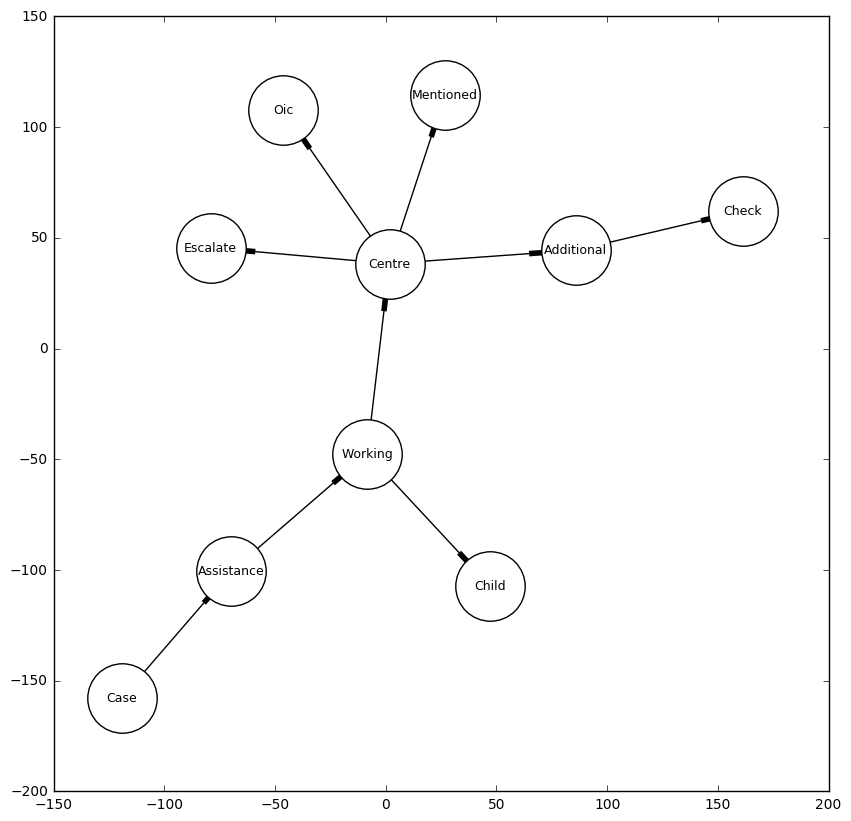

In [367]:
graph_draw(graphs[0])

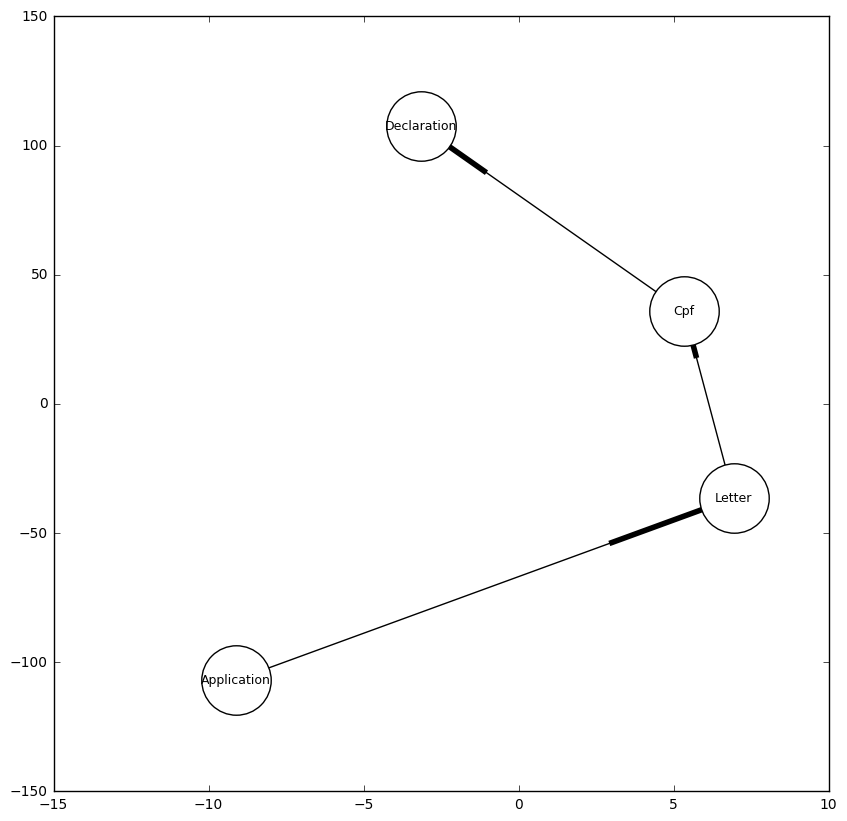

In [368]:
graph_draw(graphs[1])

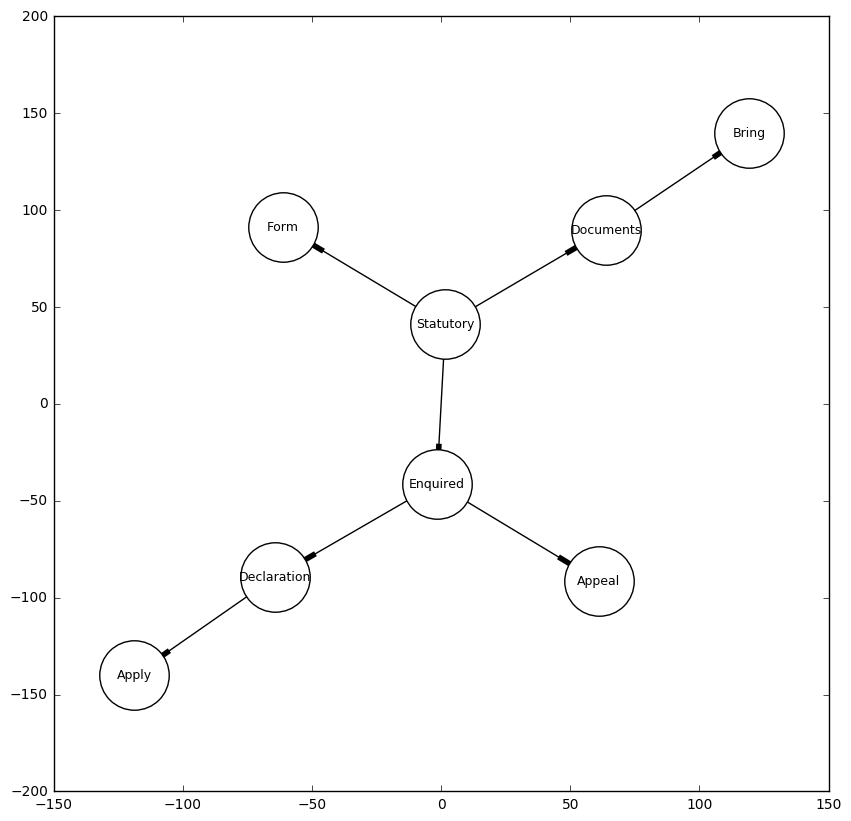

In [369]:
graph_draw(graphs[2])

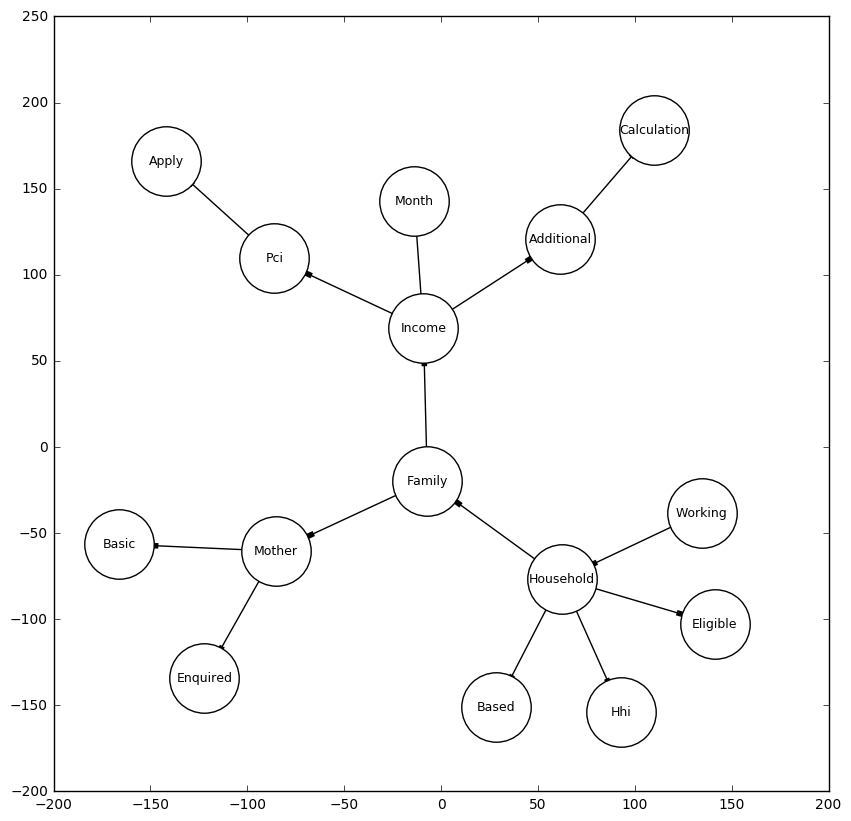

In [370]:
graph_draw(graphs[3])

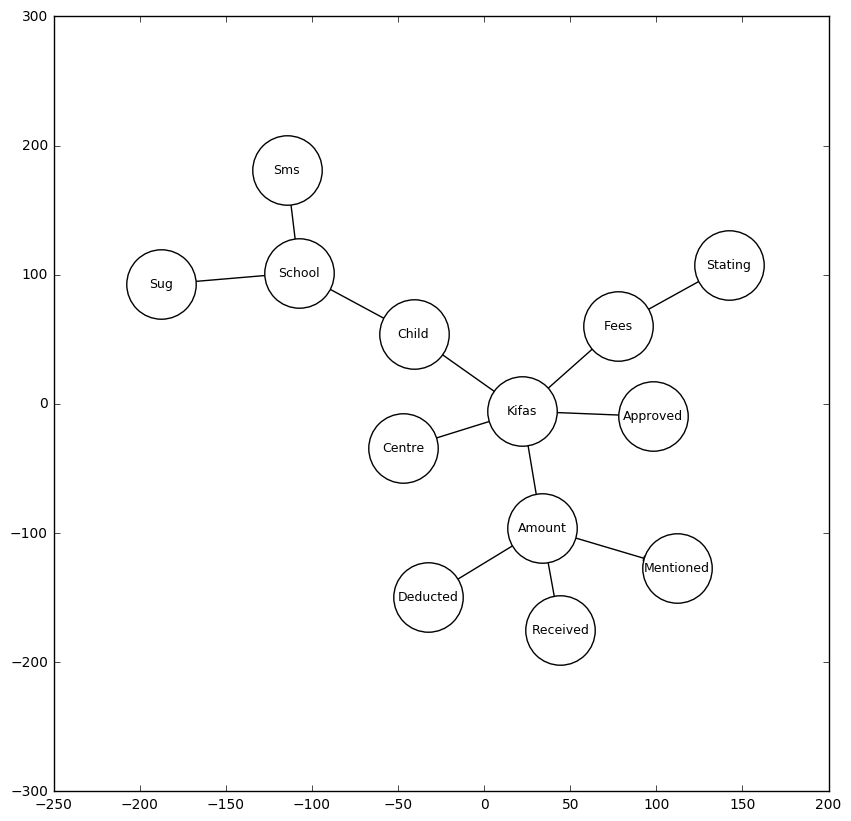

In [372]:
graph_draw(graphs[4])

In [371]:
min_count = 10
size = 50
window = 4

raw = u'\n'.join(dataHelper.text)
sents = parser(raw)
sents = removeStopwords(sents)
model = Word2Vec(sents, min_count=min_count, size=size, window=window)
vocab = model.vocab
sentBow = [keepOnly(bow, vocab) for bow in sentsToBow(sents)]
globalBow = keepOnly(sentsToGlobalBow(sents), vocab)

nodes = get_top_n_terms(globalBow, sentBow, 25)
mm = build_mind_map(model, StemmingHelper, nodes[0], nodes)
#graph_draw(mm)




In [262]:
model.save('word2vec.pickle')

In [261]:
Word2Vec.load('word2vec.pickle')